# Poro-perm Goudarzi

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pystan
import arviz as az

sns.set(style='whitegrid')

In [20]:
df = (pd.read_excel('~/Dropbox/ROZ/data/Fontainebleau/Goudarzi et al. 2018.xlsx')
     .assign(Class=lambda x: x.Class.fillna(method='ffill'),
            porosity=lambda x: x.phi * 100)
     )
df.head()

,Class,Sample,L (mm),Dm (mm),phi,k (mD),tau_h,tau_e,F,tau_e/phi,phi_c,phi-phi_c,d_min,d_max,Dp,t=D/(3-D),m,t=2m,porosity
0,A1,1,2.6571,0.176,0.1410,706.0,1.4747,1.2897,21.3457,9.146809,0.01410,0.12690,12.252799,2527.638328,2.971481,104.192724,1.562459,3.124918,14.10
1,A1,2,2.6571,0.181,0.1546,933.0,1.4716,1.2766,18.4589,8.257439,0.01546,0.13914,12.252799,2527.638328,2.968486,94.196771,1.561693,3.123386,15.46
2,A1,3,2.6571,0.180,0.1642,1126.3,1.4695,1.2681,16.7000,7.722899,0.01642,0.14778,12.252799,2527.638328,2.966343,88.135429,1.558341,3.116683,16.42
3,A1,4,2.6571,0.182,0.1795,1504.1,1.4593,1.2529,14.3050,6.979944,0.01795,0.16155,12.252799,2527.638328,2.962877,79.811506,1.549045,3.098090,17.95
4,A1,5,2.6571,0.187,0.2037,2356.0,1.4291,1.2270,11.2323,6.023564,0.02037,0.18333,12.252799,2527.638328,2.957259,69.190137,1.520195,3.040391,20.37


[None, None]

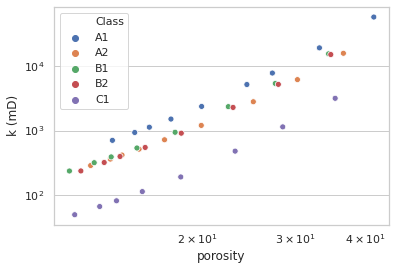

In [21]:
sns.scatterplot('porosity', 'k (mD)', hue='Class', data=df)
plt.gca().set(xscale='log', yscale='log')

In [45]:
df.porosity.describe()

count    42.000000
mean     20.908095
std       8.028362
min      11.810000
25%      14.392500
50%      18.105000
75%      26.755000
max      41.430000
Name: porosity, dtype: float64

In [24]:
model_code = """
data {
    int<lower=1> N;
    int<lower=1,upper=5> rock_class[N];
    vector[N] phi;
    vector[N] perm;
}
transformed data {
    vector [N] logperm = log(perm);
}
parameters {
    real <lower=0, upper=10> phi_critical[5];
    real <lower=0, upper=1e6> C_k[5];
    real <lower=0> t_exponent[5];
    real <lower=0> sigma_e[5];
}
model {
    phi_critical ~ cauchy(3, 1);
    t_exponent ~ normal(3, 1);
    C_k ~ cauchy(1,1);
    for (i in 1:N){
        logperm[i] ~ normal(log(C_k[rock_class[i]]) 
                + t_exponent[rock_class[i]] * log(phi[i] - phi_critical[rock_class[i]]), 
            sigma_e[rock_class[i]]);
    }
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0d94e46d70026f13642d93e444fcc121 NOW.


In [25]:
data = {
    'N': len(df.phi), 
    'phi':df.porosity, 
    'perm': df['k (mD)'],
    'rock_class':df.Class.astype('category').cat.codes + 1
}
fit = model.sampling(
    data=data, iter=5000, chains=4, warmup=1000, thin=1, seed=42, #adapt_delta = 1.0,
)
fit

Inference for Stan model: anon_model_0d94e46d70026f13642d93e444fcc121.
4 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi_critical[1]   3.62    0.02   1.32   1.04   2.77    3.5   4.44    6.4   6472    1.0
phi_critical[2]   3.52    0.01   1.23   1.09   2.73   3.42   4.27   6.11   7151    1.0
phi_critical[3]   3.53    0.01   1.17   1.25   2.77   3.44   4.26   5.98   7475    1.0
phi_critical[4]   3.73    0.01    1.3   1.28   2.86   3.59   4.57   6.43   7628    1.0
phi_critical[5]   3.89    0.02   1.62   1.13   2.81    3.6   4.83   7.57   6153    1.0
C_k[1]            0.47  6.8e-3   0.57   0.03   0.13   0.27    0.6   1.92   7159    1.0
C_k[2]            0.46  6.3e-3   0.52   0.04   0.15   0.29   0.59   1.83   6905    1.0
C_k[3]            0.54  8.1e-3   0.63   0.04   0.17   0.34   0.71   2.06   6014    1.0
C_k[4]            0.48  7.9

In [26]:
az_fit = az.from_pystan(
    fit,
    observed_data=["perm"], 
    coords={"Class": df.Class.unique()}, 
    dims = {"phi_critical": ["Class"], "C_k":["Class"], "t_exponent":["Class"]}
)

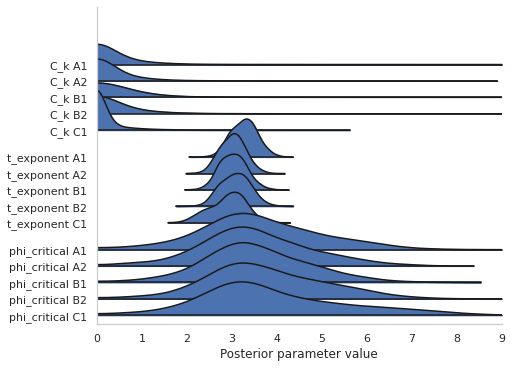

In [70]:
az.plot_forest(az_fit, var_names=['C_k', 't_exponent', 'phi_critical'], figsize=(7,5), kind='ridgeplot', combined=True)
ax = plt.gca()
ax.set(xlim=(0, 9), xlabel="Posterior parameter value")
sns.despine()
plt.savefig('bayes_figures/poroperm_Goudarzi_posterior.png', bbox_inches='tight', dpi=300)

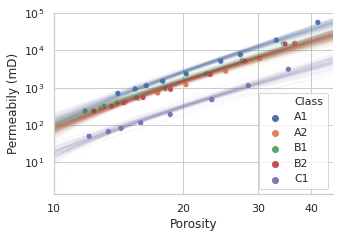

In [62]:
def log_posterior_examples(phi_predict, fit, class_number=1, num_examples=100):
    t = fit['t_exponent']
    phi_c = fit['phi_critical']
    perm0 = fit['C_k']
    samples = np.random.choice(len(t), num_examples)
    for e in samples:
        yield perm0[e, class_number] * (phi_predict - phi_c[e, class_number]) ** t[e, class_number]

phi_fit = np.linspace(10, 45, 60)
pal = sns.color_palette()

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5/1.5))
for class_number in range(5):
    for y in log_posterior_examples(phi_fit, fit, class_number, 100):
        ax1.plot(phi_fit, y, color=pal[class_number], alpha=.02)

sns.scatterplot('porosity', 'k (mD)', hue='Class', data=df, ax=ax1, alpha=1)
#sns.scatterplot('phi', 'F', hue='Class', data=df, ax=ax1)

ax1.set(
    xlabel='Porosity',
    xscale='log',
    xlim=(10, 45),
    ylabel='Permeabily (mD)',
    yscale='log', 
    ylim=(1.4, 1e5)
)
plt.legend(frameon=True)
sns.despine()
plt.xticks([10,20,30, 40],[10,20,30, 40]);
plt.savefig('bayes_figures/Goudarzi_phi-k_fit.png', dpi=300, bbox_inches='tight')